In [2]:
torch.cuda.is_available()

True

In [1]:
# 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# 이미지 데이터셋 전처리
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [4]:
# 이미지 데이터셋을 불러온 후 훈련, 검증, 테스트로 분리

img_directory = r'../DL_Data/CatDogtrain'

images_filepaths = sorted([os.path.join(img_directory, f) for f in os.listdir(img_directory)])    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:]

img2_directory = r'../DL_Data/CatDogtest'

images2_filepaths = sorted([os.path.join(img2_directory, f) for f in os.listdir(img2_directory)])    
correct_images2_filepaths = [i for i in images2_filepaths if cv2.imread(i) is not None]    

random.shuffle(correct_images2_filepaths)
val_images_filepaths = correct_images_filepaths[:700]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

25000 700 10


In [5]:
# 테스트 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-1].split('.')[0]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

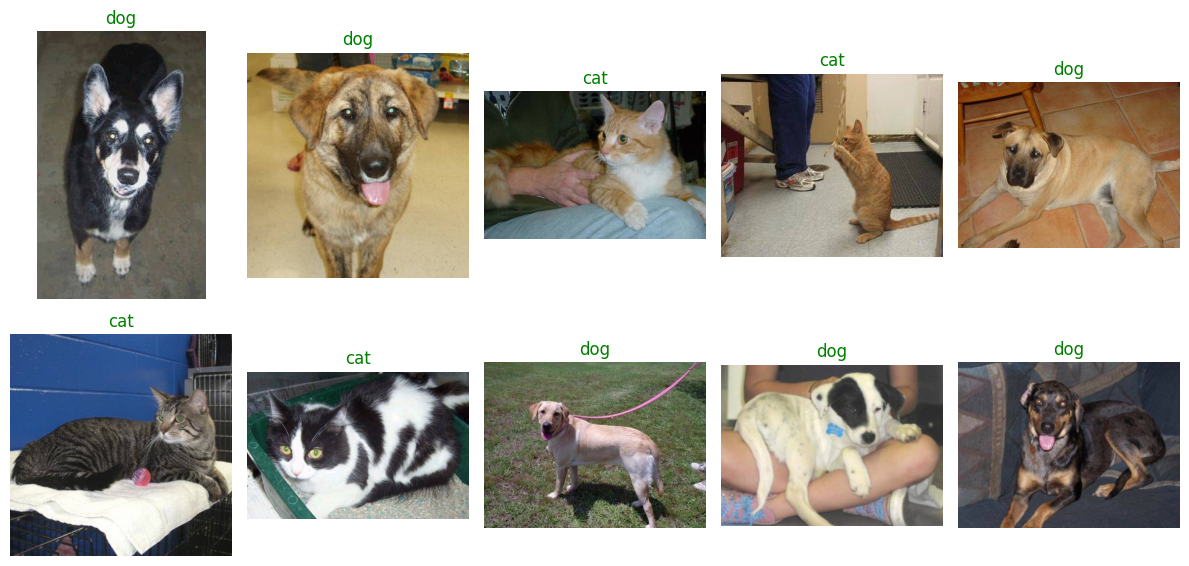

In [6]:
# 테스트 데이터셋 이미지 출력
display_image_grid(test_images_filepaths)

In [7]:
# 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'CatDogtrain\dog':
            label = 1
        elif label == 'CatDogtrain\cat':
            label = 0
        return img_transformed, label

In [8]:
# 변수 값 정의 
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 64

In [9]:
# 이미지 데이터셋 정리
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [10]:
# 데이터로더 정리 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([64, 3, 224, 224])
tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])


In [11]:
# 모델 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) 
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=3, stride=1, padding=1) 
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(72*28*28, 512) 
        self.relu4 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 100)
        self.relu5 = nn.ReLU() 
        self.fc3 = nn.Linear(100, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out)
        out = self.cnn3(out) 
        out = self.relu3(out) 
        out = self.maxpool3(out) 
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        out = self.relu5(out)
        out = self.fc3(out)
        out = self.output(out)
        return out

In [12]:
# 모델 객체 생성
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=56448, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=100, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=100, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [13]:
# 모델 객체 생성
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 72, 56, 56]          20,808
              ReLU-8           [-1, 72, 56, 56]               0
         MaxPool2d-9           [-1, 72, 28, 28]               0
           Linear-10                  [-1, 512]      28,901,888
             ReLU-11                  [-1, 512]               0
           Linear-12                  [-1, 100]          51,300
             ReLU-13                  [-1, 100]               0
           Linear-14                   

In [14]:
# 학습 가능한 파라미터 수 확인 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 28,979,286 trainable parameters


In [15]:
# 옵티마이저와 손실함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [16]:
# 모델의 파라미터와 손실함수를 GPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [19]:
# 모델학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:           
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [20]:
# 모델 학습
import time

num_epoch = 20
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/20
--------------------


C:\Users\SooHyun31\AppData\Local\Temp\ipykernel_18076\1028518339.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5431


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6910 Acc: 0.5286
Epoch 2/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6897 Acc: 0.5529


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6870 Acc: 0.5371
Epoch 3/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6827 Acc: 0.6042


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6701 Acc: 0.6414
Epoch 4/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6596 Acc: 0.6183


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6382 Acc: 0.6429
Epoch 5/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6467 Acc: 0.6209


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6293 Acc: 0.6600
Epoch 6/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6389 Acc: 0.6336


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6230 Acc: 0.6771
Epoch 7/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6292 Acc: 0.6510


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6082 Acc: 0.6986
Epoch 8/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6131 Acc: 0.6755


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.6052 Acc: 0.6814
Epoch 9/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6019 Acc: 0.6878


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5791 Acc: 0.7114
Epoch 10/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5978 Acc: 0.6933


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5707 Acc: 0.7414
Epoch 11/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5868 Acc: 0.7054


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5639 Acc: 0.7400
Epoch 12/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5779 Acc: 0.7172


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5536 Acc: 0.7543
Epoch 13/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5689 Acc: 0.7272


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5519 Acc: 0.7557
Epoch 14/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5610 Acc: 0.7387


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5335 Acc: 0.7729
Epoch 15/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5541 Acc: 0.7438


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5424 Acc: 0.7543
Epoch 16/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5501 Acc: 0.7462


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5301 Acc: 0.7757
Epoch 17/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5448 Acc: 0.7559


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5210 Acc: 0.7743
Epoch 18/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5397 Acc: 0.7597


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5231 Acc: 0.7714
Epoch 19/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5392 Acc: 0.7602


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5094 Acc: 0.7971
Epoch 20/20
--------------------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5345 Acc: 0.7658


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.5124 Acc: 0.7843
Training complete in 31m 39s
Best val Acc: 0.797143


In [88]:
# 모델 테스트를 위한 함수 정의
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('../DL_Data/LesNet.csv', index=False)

C:\Users\SooHyun31\AppData\Local\Temp\ipykernel_18076\1752552715.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
# 테스트 데이터셋의 예측결과 호출
res.head(10)

,id,label
0,10595,0.664366
1,5277,0.269160
2,5976,0.674512
3,6646,0.406041
4,6720,0.730545
5,7693,0.518379
6,8194,0.278311
7,8373,0.287598
8,940,0.395290
9,9974,0.728305


In [90]:
# 테스트 데이터셋 이미지를 출력하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

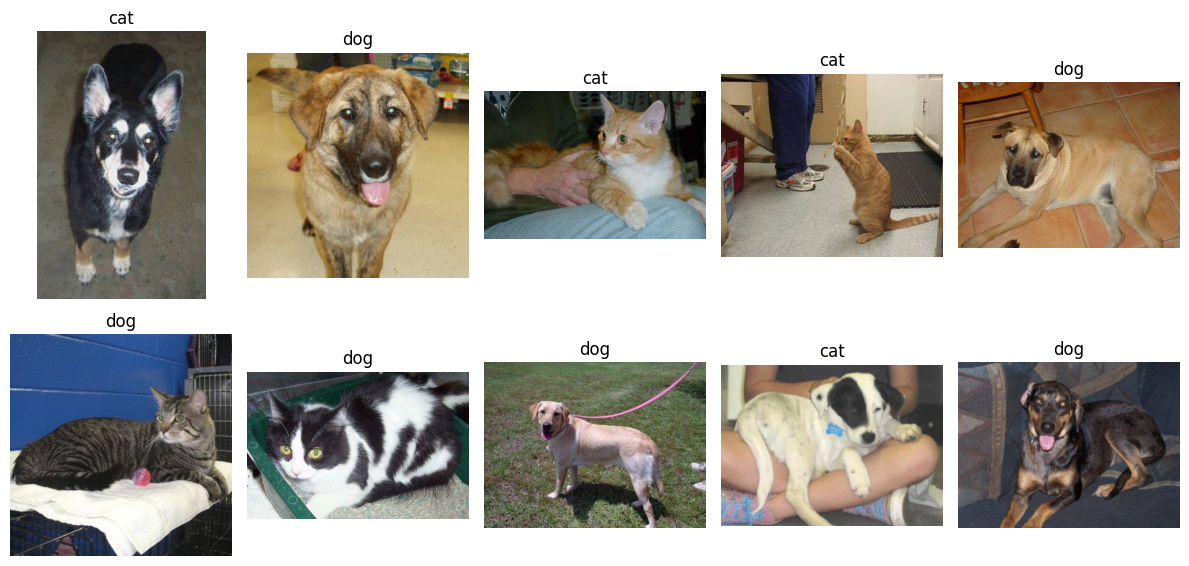

In [91]:
# 테스트 데이터셋 예측결과 이미지 출력
display_image_grid(test_images_filepaths) 

In [97]:
# 모델 저장
torch.save(model, 'model.pth')

In [98]:
# 모델 불러오기
model123 = torch.load('model.pth')

In [99]:
img_direct = r'../DL_Data/MangoStar'

img_filepaths = sorted([os.path.join(img_direct, f) for f in os.listdir(img_direct)])    
correct_img_filepaths = [i for i in img_filepaths if cv2.imread(i) is not None]    

random.shuffle(correct_img_filepaths)
test_img_filepaths = correct_img_filepaths[:]


In [100]:
pred_list1 = []
with torch.no_grad():
    for test_path in tqdm(test_img_filepaths):
        img = Image.open(test_path)
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model123.eval()
        outputs1 = model123(img)
        preds1 = F.softmax(outputs, dim=1)[:, 1].tolist()        
        pred_list1.append(preds[0])
       

C:\Users\SooHyun31\AppData\Local\Temp\ipykernel_18076\1516500646.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_img_filepaths):


  0%|          | 0/4 [00:00<?, ?it/s]

In [101]:
print(pred_list11)

[0.6745120882987976, 0.6745120882987976, 0.6745120882987976, 0.6745120882987976]


In [85]:
class_ = classes = {0:'cat', 1:'dog'}
def display_img_grid(img_filepaths, predicted_labels=(), cols=4):
    rows = len(img_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8))
    for i, img_filepath in enumerate(img_filepaths):
        img = cv2.imread(img_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if pred_list[i] > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(img)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

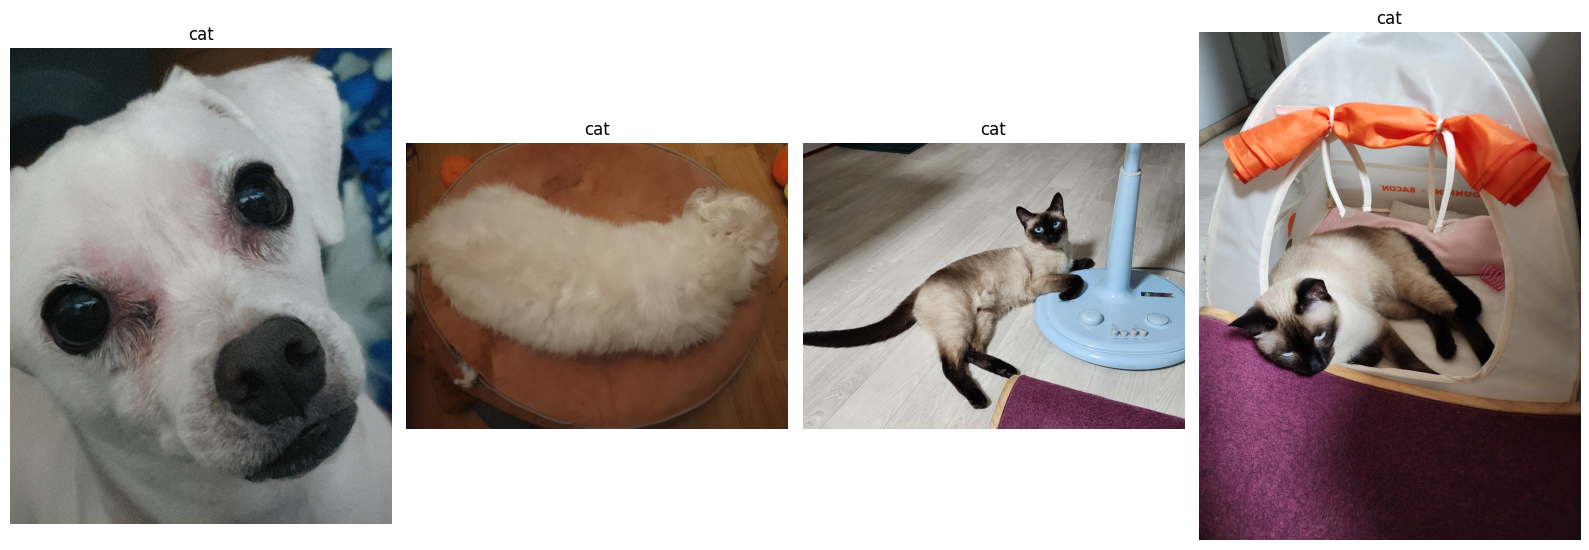

In [86]:
display_img_grid(test_img_filepaths) 